# GeoPandas IO   csv, shp geojson, etc

https://geohackweek.github.io/vector/04-geopandas-intro/


In [26]:
import os, sys,glob

import folium
from IPython.display import display

from shapely.geometry import mapping

%matplotlib inline

import pandas as pd
import geopandas as gpd

from shapely.geometry import Point

def csv2shp(csvfile):
    
    pdf = pd.read_csv(csvfile)
    mt_locations = [Point(xy) for xy in zip(pdf.lon, pdf.lat)]
    #OR pdf['geometry'] = pdf.apply(lambda z: Point(z.lon, z.lat), axis=1)
    #if you want to df = df.drop(['Lon', 'Lat'], axis=1)
    crs = {'init': 'epsg:4326'}  # WGS84
    geo_df = gpd.GeoDataFrame(pdf, crs=crs, geometry=mt_locations)

    return geo_df

In [27]:
path2csv='E:/Data/MT_Datasets/WenPingJiang_SHP/PhaseTensorTipper_Params_10Hz.csv'
path2dir=os.path.dirname(path2csv)
mygdf=csv2shp(path2csv)

In [28]:
mygdf.head()

,station,lon,lat,phi_min,phi_max,skew,ellipticity,azimuth,tip_mag_re,tip_ang_re,tip_mag_im,tip_ang_im,frequency,geometry
0,10020,144.1380,-23.2889,47.4429,49.2032,0.0328,0.0182,-41.8408,0.0000,-180.0000,0.0000,-180.0000,10.254,POINT (144.138 -23.2889)
1,10030,144.1123,-23.2511,45.7222,47.3457,0.0306,0.0174,-14.8722,0.0000,-180.0000,0.0000,-180.0000,10.254,POINT (144.1123 -23.2511)
2,10040,144.0786,-23.2121,44.7288,46.6450,-0.0857,0.0210,-53.8707,0.0000,-180.0000,0.0000,-180.0000,10.254,POINT (144.0786 -23.2121)
3,10050,144.0539,-23.1816,41.0977,41.5045,-0.0119,0.0049,-62.9109,0.0111,98.9884,0.0190,10.0802,10.254,POINT (144.0539 -23.1816)
4,10060,144.0249,-23.1491,39.0039,41.5335,-0.0238,0.0314,82.0232,0.0076,108.0656,0.0077,98.6999,10.625,POINT (144.0249 -23.1491)


In [29]:
mygdf.crs

{'init': 'epsg:4326'}

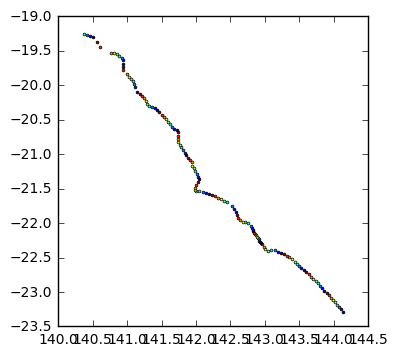

In [30]:
mygdf.plot()

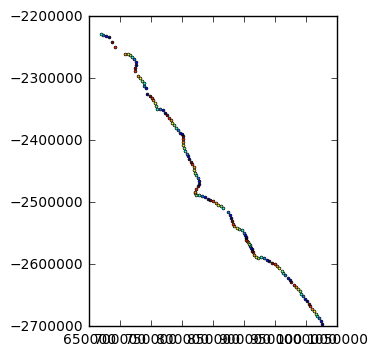

In [28]:
mygdf.to_crs({'init':'epsg:3112'}).plot()  # 3112 is GDA94/GALambertConformal

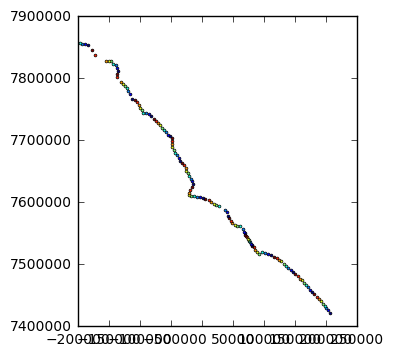

In [29]:
mygdf.to_crs({'init':'epsg:32755'}).plot()

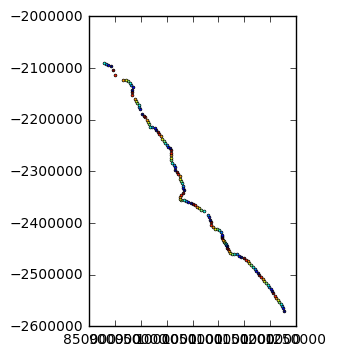

In [30]:
mygdf.to_crs({'init':'epsg:3577'}).plot()  #EPSG Projection 3577 - GDA94 / Australian Albers 

In [6]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['lines.color'] = 'r'

#mpl.rcParams['figure.figsize']=(8,30)

In [7]:
gdf_utm54=mygdf.to_crs({'init':'epsg:32754'})  #.plot()
outshp=os.path.join(path2dir,'geopandas_made_utm54.shp')
gdf_utm54.to_file(outshp, driver='ESRI Shapefile')

In [8]:
outshp=os.path.join(path2dir,'geopandas_made.shp')
mygdf.to_file(outshp, driver='ESRI Shapefile')

In [9]:

geojson = mygdf.to_json()
bounds = mygdf.total_bounds


In [10]:
print bounds

(140.38040000000001, -23.288900000000002, 144.13800000000001, -19.2547)


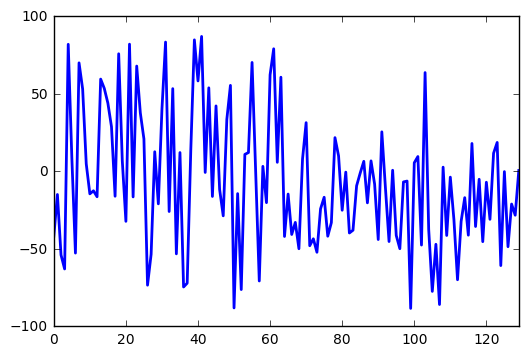

In [11]:
mygdf['azimuth'].plot()

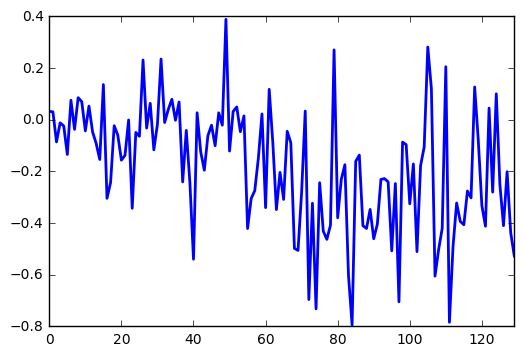

In [12]:
mygdf['skew'].plot()

In [13]:
mygdf.columns

Index([u'station', u'lon', u'lat', u'phi_min', u'phi_max', u'skew',
       u'ellipticity', u'azimuth', u'tip_mag_re', u'tip_ang_re', u'tip_mag_im',
       u'tip_ang_im', u'frequency', u'geometry'],
      dtype='object')

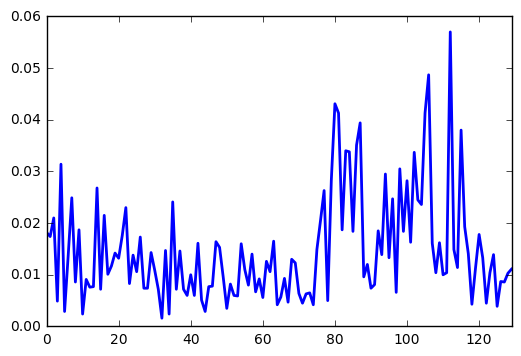

In [14]:
mygdf['ellipticity'].plot()

In [15]:
mygdf['ellipticity'].describe()

count    130.000000
mean       0.014770
std        0.010434
min        0.001600
25%        0.007400
50%        0.011850
75%        0.018350
max        0.057000
Name: ellipticity, dtype: float64

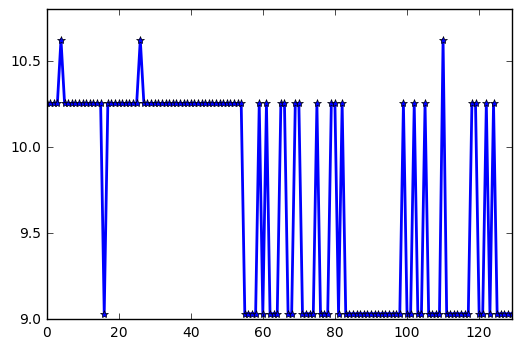

In [16]:
mygdf['frequency'].plot(marker='*')   # tolerance ftol=10%

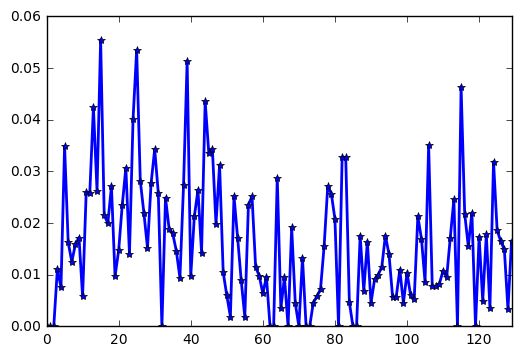

In [17]:
mygdf['tip_mag_re'].plot(marker='*')  

#mygdf['tip_ang_re'].plot(marker='*')  

In [18]:
# output jeojson?

In [19]:
import pandas as pd
import geopandas
from shapely.geometry import Point, Polygon, LineString
import os

def demo_csv2shape(datas=None):
    
    
    data = [
            {'some_attribute': 'abc', 'lat': '50.1234', 'lon': '10.4023'},
            {'some_attribute': 'def', 'lat': '40.5678', 'lon': '8.3365'},
            {'some_attribute': 'ghi', 'lat': '60.9012', 'lon': '6.2541'},
            {'some_attribute': 'jkl', 'lat': '45.3456', 'lon': '12.5478'},
            {'some_attribute': 'mno', 'lat': '35.7890', 'lon': '14.3957'},
            ]

    df = pd.DataFrame(data)
    print(df)

    # to see the funciton params:  df.to_csv?
    df.to_csv('my_csv1.csv'); 
    df.to_csv('my_csv1.csv', mode='a', header=False)  #defaut mode='w' and header=Trure

    # now do this run 
    df.to_csv('my_csv2.csv'); 
    df.to_csv('my_csv2.csv', mode='a')  # header repeated

    # combine lat and lon column to a shapely Point() object
    # Point-OK: df['geometry'] = df.apply(lambda x: Point((float(x.lon), float(x.lat))), axis=1)
    
    df['geometry'] = df.apply(lambda x: LineString([(float(x.lon), float(x.lat)), (float(x.lon)+1,float(x.lat)+2)]), axis=1)

    df = geopandas.GeoDataFrame(df, geometry='geometry')

    df.to_file('MyGeometries.shp', driver='ESRI Shapefile')

    # proj WGS84

    df.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

    df.to_file('MyGeometries2.shp', driver='ESRI Shapefile')
    
    print os.getcwd()
    
    return df
                                              
                                              

In [20]:
df=demo_csv2shape()

       lat      lon some_attribute
0  50.1234  10.4023            abc
1  40.5678   8.3365            def
2  60.9012   6.2541            ghi
3  45.3456  12.5478            jkl
4  35.7890  14.3957            mno
E:\Githubz\mtpy2\examples\notebooks


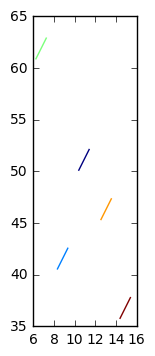

In [21]:
df.plot()

In [22]:
df

,lat,lon,some_attribute,geometry
0,50.1234,10.4023,abc,"LINESTRING (10.4023 50.1234, 11.4023 52.1234)"
1,40.5678,8.3365,def,"LINESTRING (8.336499999999999 40.5678, 9.33649..."
2,60.9012,6.2541,ghi,"LINESTRING (6.2541 60.9012, 7.2541 62.9012)"
3,45.3456,12.5478,jkl,"LINESTRING (12.5478 45.3456, 13.5478 47.3456)"
4,35.7890,14.3957,mno,"LINESTRING (14.3957 35.789, 15.3957 37.789)"


## https://geohackweek.github.io/vector/04-geopandas-intro/

OR

## http://nbviewer.jupyter.org/github/geohackweek/vector/blob/gh-pages/docker/notebooks/geopandas_intro.ipynb
Like shapely, these spatial data types are limited to discrete entities/features and do not address continuously varying rasters or fields.

While GeoPandas spatial objects can be assigned a Coordinate Reference System (CRS), operations can not be performed across CRS’s. Plus, geodetic (“unprojected”, lat-lon) CRS are not handled in a special way; the area of a geodetic polygon will be in degrees.


In [20]:
mygdf.iloc[-1]  # last row or feature

station                        11330a   
lon                               140.38
lat                             -19.2547
phi_min                          48.4315
phi_max                          49.5213
skew                             -0.5275
ellipticity                       0.0111
azimuth                           0.6206
tip_mag_re                        0.0165
tip_ang_re                        113.97
tip_mag_im                        0.0015
tip_ang_im                       54.2814
frequency                         9.0332
geometry       POINT (140.3804 -19.2547)
Name: 129, dtype: object

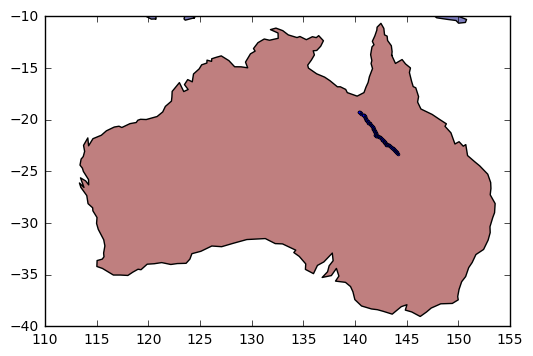

In [21]:
# geopandas included shape datasets
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
myax=world.plot(alpha=0.5)

myax.set_xlim([138,150])
myax.set_ylim([-30,-10])

myax.set_xlim([110,155])
myax.set_ylim([-40,-10])
              
mygdf.plot(ax=myax, figsize=(10, 20), marker='o', color='blue', markersize=2);

# Construct phase_tensor Ellipses and Tippers 

# write to shape files with different projections: wgs84, utm, etc.

In [ ]:

def create_phase_tensor_shp(csvfile):
    
    pdf = pd.read_csv(csvfile)
    geometry = [Point(xy) for xy in zip(pdf.lon, pdf.lat)]
    #OR pdf['geometry'] = pdf.apply(lambda z: Point(z.lon, z.lat), axis=1)
    #if you want to df = df.drop(['Lon', 'Lat'], axis=1)
    crs = {'init': 'epsg:4326'}  # WGS84
    geo_df = gpd.GeoDataFrame(pdf, crs=crs, geometry=geometry)

    return geo_df